In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Ana aktiviteler
logon_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/büyük veri/logon.csv', parse_dates=['date'], dayfirst=True)
device_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/büyük veri/device.csv', parse_dates=['date'], dayfirst=True)
file_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/büyük veri/file.csv', parse_dates=['date'], dayfirst=True)

# Psikometrik veriler
psychometric_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/büyük veri/psychometric.csv')

# LDAP dosyalarının birleştirilmesi
import glob
import os

ldap_files = glob.glob("/content/drive/MyDrive/Colab Notebooks/büyük veri/LDAP/*.csv")
ldap_list = []

for file in ldap_files:
    df = pd.read_csv(file, usecols=['employee_name', 'user_id', 'role'])
    ldap_list.append(df)

ldap_df = pd.concat(ldap_list, ignore_index=True).drop_duplicates()


In [4]:
logon_df.shape


(854859, 5)

In [5]:
device_df.shape



(405380, 5)

In [6]:
file_df.shape

(445581, 6)

In [7]:
psychometric_df.shape

(1000, 7)

In [8]:
# Tarihlerin doğru formatta olduğundan emin ol
print(logon_df['date'].dtype)
print(device_df['date'].dtype)
print(file_df['date'].dtype)


object
object
object


In [9]:
print("Logon unique users:", logon_df['user'].nunique())
print("Device unique users:", device_df['user'].nunique())
print("File unique users:", file_df['user'].nunique())
print("Psychometric users:", psychometric_df['user_id'].nunique())
print("LDAP users:", ldap_df['user_id'].nunique())


Logon unique users: 1000
Device unique users: 265
File unique users: 264
Psychometric users: 1000
LDAP users: 1000


In [10]:
logon_df['date'] = pd.to_datetime(logon_df['date'], dayfirst=True, errors='coerce')
device_df['date'] = pd.to_datetime(device_df['date'], dayfirst=True, errors='coerce')
file_df['date'] = pd.to_datetime(file_df['date'], dayfirst=True, errors='coerce')

# Kontrol
print("Logon:", logon_df['date'].dtype)
print("Device:", device_df['date'].dtype)
print("File:", file_df['date'].dtype)


Logon: datetime64[ns]
Device: datetime64[ns]
File: datetime64[ns]


In [11]:
#Logon Anomali 1 : Beklenmedik saatlerde logon yapılması (gece saatleri)

# Yeni sütunlar: saat ve haftanın günü
logon_df['hour'] = logon_df['date'].dt.hour
logon_df['weekday'] = logon_df['date'].dt.dayofweek  # 0 = Pazartesi, ..., 6 = Pazar

# Gece saati kontrolü (22 <= saat veya saat < 6)
logon_df['is_night'] = (logon_df['hour'] >= 22) | (logon_df['hour'] < 6)

# Hafta sonu kontrolü (5 = Cumartesi, 6 = Pazar)
logon_df['is_weekend'] = logon_df['weekday'] >= 5

# En az bir kuralı sağlayanlar
logon_anomalies_time = logon_df[
    (logon_df['is_night']) | (logon_df['is_weekend'])
].copy()

# Anomali nedenini yaz
logon_anomalies_time['anomaly_reason'] = logon_anomalies_time.apply(
    lambda row: "Gece saati" if row['is_night'] and not row['is_weekend']
    else ("Hafta sonu giriş" if row['is_weekend'] and not row['is_night']
          else "Gece saati ve hafta sonu giriş"), axis=1
)

# pc bilgisi dahil olarak anomali tablosunu oluştur
logon_anomalies_1 = logon_anomalies_time[['date', 'user', 'pc', 'anomaly_reason']]
logon_anomalies_1.head()


,date,user,pc,anomaly_reason
129,2010-03-01 00:56:15,BSS0369,PC-8884,Gece saati
130,2010-03-01 01:12:00,BSS0369,PC-8884,Gece saati
274,2010-04-01 00:04:43,JGT0221,PC-3814,Gece saati
275,2010-04-01 00:11:32,JGT0221,PC-3814,Gece saati
276,2010-04-01 00:12:17,MVH0373,PC-4176,Gece saati


In [12]:
#Logon Anomali 2 : Farklı PC'lerden kısa sürede giriş

from datetime import timedelta

# Sadece Logon olaylarını al
logon_logons = logon_df[logon_df['activity'] == 'Logon'].copy()
logon_logons.sort_values(by=['user', 'date'], inplace=True)

# Kullanıcının önceki cihaz ve giriş zamanı
logon_logons['prev_pc'] = logon_logons.groupby('user')['pc'].shift()
logon_logons['prev_date'] = logon_logons.groupby('user')['date'].shift()

# Zaman farkı hesapla
logon_logons['time_diff'] = (logon_logons['date'] - logon_logons['prev_date'])

# Aynı kullanıcı kısa sürede farklı PC'lerden giriş yaptıysa (15 dk kuralı)
logon_logons['anomaly'] = (logon_logons['pc'] != logon_logons['prev_pc']) & (logon_logons['time_diff'] <= timedelta(minutes=15))

# Anomalileri filtrele
multiple_pc_anomalies = logon_logons[logon_logons['anomaly'] == True].copy()
multiple_pc_anomalies['anomaly_reason'] = "Farklı PC'lerden kısa sürede giriş"

# Son tablo
logon_anomalies_2 = multiple_pc_anomalies[['date', 'user', 'anomaly_reason']]
logon_anomalies_2.head()


,date,user,anomaly_reason
338228,2010-06-07 08:19:06,ABM0845,Farklı PC'lerden kısa sürede giriş
343330,2010-08-07 08:37:00,ABM0845,Farklı PC'lerden kısa sürede giriş
277579,2010-01-06 19:04:03,ACC0042,Farklı PC'lerden kısa sürede giriş
336575,2010-02-07 18:11:55,ACC0042,Farklı PC'lerden kısa sürede giriş
597873,2010-02-12 20:37:04,ACC0042,Farklı PC'lerden kısa sürede giriş


In [13]:
#Logon Anomali 2 :Yeni cihazlardan giriş
# Ön hazırlık: tarih sırasına göre sırala
logon_df = logon_df.sort_values(by=['user', 'date']).copy()

# Her kullanıcı için daha önce bağlandığı cihazlar kümesini takip etmek için boş sözlük
user_known_pcs = {}

# Yeni cihaz girişlerini saklamak için liste
new_device_logins = []

# Her satırı döngüyle kontrol et
for index, row in logon_df.iterrows():
    user = row['user']
    pc = row['pc']

    if user not in user_known_pcs:
        # İlk kez görülen kullanıcı için cihaz kümesini oluştur
        user_known_pcs[user] = set([pc])
        # İlk giriş de yeni cihaz sayılır
        new_device_logins.append((row['date'], user, pc, 'İlk kez görülen kullanıcı - cihaz girşi'))

    elif pc not in user_known_pcs[user]:
        # Kullanıcının daha önce hiç kullanmadığı cihaz
        new_device_logins.append((row['date'], user, pc, 'Yeni cihazdan giriş'))
        user_known_pcs[user].add(pc)

# Yeni cihazdan girişleri DataFrame olarak düzenle
logon_anomalies_3 = pd.DataFrame(new_device_logins, columns=['date', 'user', 'pc', 'anomaly_reason'])

# İlk 10 anomaliyi göster
logon_anomalies_3.head(10)



,date,user,pc,anomaly_reason
0,2010-01-02 08:05:00,AAE0190,PC-8915,İlk kez görülen kullanıcı - cihaz girşi
1,2010-01-02 09:07:00,AAF0535,PC-2408,İlk kez görülen kullanıcı - cihaz girşi
2,2010-01-02 08:08:00,AAF0791,PC-7357,İlk kez görülen kullanıcı - cihaz girşi
3,2010-01-02 07:48:00,AAL0706,PC-5282,İlk kez görülen kullanıcı - cihaz girşi
4,2010-01-02 09:16:00,AAM0658,PC-9923,İlk kez görülen kullanıcı - cihaz girşi
5,2010-01-02 08:20:00,AAN0823,PC-7708,İlk kez görülen kullanıcı - cihaz girşi
6,2010-01-02 08:01:00,AAS0442,PC-1039,İlk kez görülen kullanıcı - cihaz girşi
7,2010-01-02 08:00:00,AAV0450,PC-6419,İlk kez görülen kullanıcı - cihaz girşi
8,2010-01-02 07:54:00,AAW0353,PC-8732,İlk kez görülen kullanıcı - cihaz girşi
9,2010-01-02 07:47:00,ABC0174,PC-5156,İlk kez görülen kullanıcı - cihaz girşi


In [14]:
# Tabloları birleştir
logon_anomalies_final = pd.concat([logon_anomalies_1, logon_anomalies_2, logon_anomalies_3], ignore_index=True)

# Tarihe göre sırala (isteğe bağlı)
logon_anomalies_final.sort_values(by='date', inplace=True)

# İlk satırlara göz atalım
logon_anomalies_final.head()


,date,user,pc,anomaly_reason
130039,2010-01-02 00:16:44,JAJ0849,PC-9819,İlk kez görülen kullanıcı - cihaz girşi
5879,2010-01-02 00:16:44,JAJ0849,PC-9819,Gece saati ve hafta sonu giriş
5880,2010-01-02 00:19:22,WPR0368,PC-1736,Gece saati ve hafta sonu giriş
143782,2010-01-02 00:19:22,WPR0368,PC-1736,İlk kez görülen kullanıcı - cihaz girşi
137787,2010-01-02 00:22:13,MPM0220,PC-3842,İlk kez görülen kullanıcı - cihaz girşi


In [15]:
#Device Anomali 1: Beklenmedik Saatlerde Kullanım (Gece/Hafta Sonu)
# Saat ve gün bilgilerini çıkar
device_df['hour'] = device_df['date'].dt.hour
device_df['weekday'] = device_df['date'].dt.dayofweek  # 0 = Pazartesi

# Gece saati ve hafta sonu kontrolleri
device_df['is_night'] = (device_df['hour'] >= 22) | (device_df['hour'] < 6)
device_df['is_weekend'] = device_df['weekday'] >= 5

# En az birini sağlayanlar
device_anomalies_time = device_df[
    device_df['is_night'] | device_df['is_weekend']
].copy()

# Anomali nedenini belirle
device_anomalies_time['anomaly_reason'] = device_anomalies_time.apply(
    lambda row: "Gece saati bağlanma" if row['is_night'] and not row['is_weekend']
    else ("Hafta sonu bağlanma" if row['is_weekend'] and not row['is_night']
          else "Gece saati ve hafta sonu bağlanma"), axis=1
)

# Son tablo
device_anomalies_1 = device_anomalies_time[['date', 'user', 'pc', 'anomaly_reason']]
device_anomalies_1.head()


,date,user,pc,anomaly_reason
116,2010-03-01 01:10:23,BSS0369,PC-8884,Gece saati bağlanma
117,2010-03-01 01:10:28,BSS0369,PC-8884,Gece saati bağlanma
264,2010-04-01 00:20:11,MOS0047,PC-5909,Gece saati bağlanma
265,2010-04-01 00:20:56,MOS0047,PC-5909,Gece saati bağlanma
266,2010-04-01 02:37:15,EIS0041,PC-5508,Gece saati bağlanma


In [16]:
# Device Anomali 2: İlk Kez Kullanılan Cihazdan Bağlantı
# Her kullanıcı için daha önce hangi cihazlara bağlandığını takip etmek için küme
seen_user_pc = set()
new_device_events = []

for idx, row in device_df.iterrows():
    key = (row['user'], row['pc'])
    if key not in seen_user_pc:
        seen_user_pc.add(key)
        new_device_events.append({
            'date': row['date'],
            'user': row['user'],
            'pc': row['pc'],
            'anomaly_reason': 'İlk kez kullanılan cihaz bağlantısı'
        })

device_anomalies_2 = pd.DataFrame(new_device_events)
device_anomalies_2.head()

,date,user,pc,anomaly_reason
0,2010-02-01 07:21:06,MOH0273,PC-6699,İlk kez kullanılan cihaz bağlantısı
1,2010-02-01 07:59:11,HPH0075,PC-2417,İlk kez kullanılan cihaz bağlantısı
2,2010-02-01 07:59:49,IIW0249,PC-0843,İlk kez kullanılan cihaz bağlantısı
3,2010-02-01 08:24:54,HSB0196,PC-8001,İlk kez kullanılan cihaz bağlantısı
4,2010-02-01 08:25:18,RRC0553,PC-6672,İlk kez kullanılan cihaz bağlantısı


In [17]:
#Device Anomali 3: Aynı Anda Birden Fazla Cihazda Bağlı Olma

from datetime import timedelta

# Sadece 'Connect' olaylarını al, sıralayıp önceki bağlantıyı takip et
device_connects = device_df[device_df['activity'] == 'Connect'].copy()
device_connects.sort_values(by=['user', 'date'], inplace=True)

device_connects['prev_pc'] = device_connects.groupby('user')['pc'].shift()
device_connects['prev_date'] = device_connects.groupby('user')['date'].shift()
device_connects['time_diff'] = device_connects['date'] - device_connects['prev_date']

# Kısa sürede farklı PC bağlantısı
device_connects['anomaly'] = (device_connects['pc'] != device_connects['prev_pc']) & \
                             (device_connects['time_diff'] <= timedelta(minutes=5))

# Anomalileri filtrele
simultaneous_device_use = device_connects[device_connects['anomaly'] == True].copy()
simultaneous_device_use['anomaly_reason'] = "Kısa sürede çoklu cihaz kullanımı"

device_anomalies_3 = simultaneous_device_use[['date', 'user', 'pc', 'anomaly_reason']]
device_anomalies_3.head()

,date,user,pc,anomaly_reason
184519,2010-02-08 03:27:33,AJF0370,PC-1708,Kısa sürede çoklu cihaz kullanımı
135184,2010-04-06 11:52:32,AJF0370,PC-8651,Kısa sürede çoklu cihaz kullanımı
55896,2010-05-03 07:20:32,AJF0370,PC-5027,Kısa sürede çoklu cihaz kullanımı
266033,2010-05-11 13:07:11,AJF0370,PC-8651,Kısa sürede çoklu cihaz kullanımı
3901,2010-06-01 22:44:29,AJF0370,PC-6610,Kısa sürede çoklu cihaz kullanımı


In [18]:
device_anomalies_final = pd.concat([
    device_anomalies_1,
    device_anomalies_2,
    device_anomalies_3
], ignore_index=True).sort_values(by='date')
device_anomalies_final.head()

,date,user,pc,anomaly_reason
53731,2010-01-02 00:23:17,MPM0220,PC-3842,İlk kez kullanılan cihaz bağlantısı
2664,2010-01-02 00:23:17,MPM0220,PC-3842,Gece saati ve hafta sonu bağlanma
2665,2010-01-02 00:23:30,MPM0220,PC-3842,Gece saati ve hafta sonu bağlanma
2666,2010-01-02 01:32:06,MPM0220,PC-8851,Gece saati ve hafta sonu bağlanma
53732,2010-01-02 01:32:06,MPM0220,PC-8851,İlk kez kullanılan cihaz bağlantısı


In [19]:
#File Anomali 1: Alışılmadık Dosya Türlerine Erişim

# Dosya uzantısını çıkar
file_df['extension'] = file_df['filename'].str.extract(r'\.([a-zA-Z0-9]+)$')

# Kullanıcının eriştiği önceki uzantı profili
seen_extensions = {}

# Anomalileri tutacak liste
unusual_filetype_anomalies = []

# Tarihe göre sırala
file_df = file_df.sort_values(by='date')

# Her satırı gez
for idx, row in file_df.iterrows():
    user = row['user']
    ext = row['extension']

    if pd.isna(ext):
        continue

    # Daha önce bu kullanıcı bu uzantıya erişti mi?
    if user not in seen_extensions:
        seen_extensions[user] = set()

    if ext not in seen_extensions[user]:
        # Anomali: bu kullanıcı bu uzantıya ilk kez erişiyor
        unusual_filetype_anomalies.append({
            'date': row['date'],
            'user': user,
            'pc': row['pc'],
            'filename': row['filename'],
            'extension': ext,
            'anomaly_reason': 'Alışılmadık dosya uzantısı'
        })

    # Erişilen uzantıyı profile ekle
    seen_extensions[user].add(ext)

# Sonuçları DataFrame olarak kaydet
file_anomalies_1 = pd.DataFrame(unusual_filetype_anomalies)

# İlk 10 sonucu göster
file_anomalies_1.head(10)


,date,user,pc,filename,extension,anomaly_reason
0,2010-01-02 00:23:21,MPM0220,PC-3842,VY9WYR5Z.pdf,pdf,Alışılmadık dosya uzantısı
1,2010-01-02 00:23:27,MPM0220,PC-3842,6G6S80CE.txt,txt,Alışılmadık dosya uzantısı
2,2010-01-02 00:23:28,MPM0220,PC-3842,Z229DJ9V.doc,doc,Alışılmadık dosya uzantısı
3,2010-01-02 03:48:55,MOS0047,PC-1013,16OJ45RB.doc,doc,Alışılmadık dosya uzantısı
4,2010-01-02 03:49:50,MOS0047,PC-1013,W4PPZN2V.pdf,pdf,Alışılmadık dosya uzantısı
5,2010-01-02 04:26:53,BAL0044,PC-1187,11FDOY7M.zip,zip,Alışılmadık dosya uzantısı
6,2010-01-02 04:33:27,MPM0220,PC-9508,9TOU1YUI.jpg,jpg,Alışılmadık dosya uzantısı
7,2010-01-02 05:05:50,IBB0359,PC-2930,7978CK73.pdf,pdf,Alışılmadık dosya uzantısı
8,2010-01-02 05:05:52,IBB0359,PC-2930,CI06RXNM.exe,exe,Alışılmadık dosya uzantısı
9,2010-01-02 05:05:58,IBB0359,PC-2930,91I4O42G.jpg,jpg,Alışılmadık dosya uzantısı


In [20]:
#File Anomali 2:Alışılmadık Dosya İçeriği Tespiti (magic number ile)
import pandas as pd

# Magic number eşleştirmeleri
magic_headers = {
    "doc": ["D0-CF-11-E0-A1-B1-1A-E1"],
    "xls": ["D0-CF-11-E0-A1-B1-1A-E1"],
    "ppt": ["D0-CF-11-E0-A1-B1-1A-E1"],
    "pdf": ["25-50-44-46", "25-50-44-46-2D"],
    "jpg": ["FF-D8"],
    "exe": ["4D-5A"],
    "zip": ["50-4B-03-04", "50-4B-05-06", "50-4B-07-08"],
    "txt": [],  # Düz metin; magic header olmayabilir
}

# Uzantı ve içerik başı çıkarımı
file_df["extension"] = file_df["filename"].str.extract(r"\.([a-zA-Z0-9]+)$")
file_df["content_prefix"] = file_df["content"].str.slice(0, 20)

# Magic uyumu kontrol fonksiyonu
def check_magic_match(ext, prefix):
    if pd.isna(ext) or pd.isna(prefix):
        return False
    ext = ext.lower()
    known_headers = magic_headers.get(ext, [])
    return any(prefix.startswith(h) for h in known_headers)

# Uyum kontrolü ve anomali gerekçesi
file_df["content_match_extension"] = file_df.apply(
    lambda row: check_magic_match(row["extension"], row["content_prefix"]),
    axis=1
)

file_df["anomaly_reason"] = file_df["content_match_extension"].apply(
    lambda match: None if match else "Dosya içeriği uzantıyla uyumsuz"
)

# Anomalileri içeren yeni DataFrame
file_anomalies_2 = file_df[file_df["anomaly_reason"].notna()][
    ["date", "user", "pc", "filename", "extension", "content_prefix", "anomaly_reason"]
].reset_index(drop=True)

file_anomalies_2.head()


,date,user,pc,filename,extension,content_prefix,anomaly_reason
0,2010-01-02 00:23:27,MPM0220,PC-3842,6G6S80CE.txt,txt,50-53-56-57 because,Dosya içeriği uzantıyla uyumsuz
1,2010-01-02 00:23:27,MPM0220,PC-3842,IP7E09KZ.txt,txt,32-44-34-47 importan,Dosya içeriği uzantıyla uyumsuz
2,2010-01-02 00:23:28,MPM0220,PC-3842,Z229DJ9V.doc,doc,D0-CF-11-E0-A1-B1-1A,Dosya içeriği uzantıyla uyumsuz
3,2010-01-02 03:48:55,MOS0047,PC-1013,16OJ45RB.doc,doc,D0-CF-11-E0-A1-B1-1A,Dosya içeriği uzantıyla uyumsuz
4,2010-01-02 03:50:53,MOS0047,PC-1013,TPZXQRKD.doc,doc,D0-CF-11-E0-A1-B1-1A,Dosya içeriği uzantıyla uyumsuz


In [21]:
#File Anomali 3: Kısa Sürede Çok Çeşitli Dosya Türü Erişimi (Rapid Diverse File Access)
import pandas as pd
from datetime import timedelta

# Tarih sütununu datetime tipine çevir
file_df['date'] = pd.to_datetime(file_df['date'])

# Dosya uzantısını çıkar (eğer henüz yoksa)
file_df['extension'] = file_df['filename'].str.extract(r'\.([a-zA-Z0-9]+)$')

# Kullanıcı bazında sırala
file_df_sorted = file_df.sort_values(by=['user', 'date']).reset_index(drop=True)

anomalies = []

# Her kullanıcı için işle
for user, group in file_df_sorted.groupby('user'):
    group = group.reset_index(drop=True)
    for i in range(len(group)):
        start_time = group.loc[i, 'date']
        end_time = start_time + timedelta(minutes=15)

        # 15 dakika aralığındaki kayıtları al
        window = group[(group['date'] >= start_time) & (group['date'] <= end_time)]

        # Benzersiz uzantıları kontrol et
        unique_exts = window['extension'].dropna().unique()

        if len(unique_exts) >= 3:
            anomalies.append({
                'user': user,
                'start_time': start_time,
                'end_time': window['date'].max(),
                'file_count': len(window),
                'unique_extensions': list(unique_exts),
                'filenames': list(window['filename']),
                'anomaly_reason': 'Kısa sürede çok çeşitli dosya türü erişimi'
            })

# Anomalileri DataFrame'e çevir
file_anomalies_3 = pd.DataFrame(anomalies)


In [22]:
file_anomalies_3.head()

,user,start_time,end_time,file_count,unique_extensions,filenames,anomaly_reason
0,AAF0535,2010-02-02 14:10:09,2010-02-02 14:10:54,3,"[jpg, doc, pdf]","[83W508X5.jpg, 8NNJOIJI.doc, 6XGHCGK0.pdf]",Kısa sürede çok çeşitli dosya türü erişimi
1,AAF0535,2010-08-07 09:44:23,2010-08-07 09:49:28,3,"[txt, exe, pdf]","[U56TCVVG.txt, WSU30THE.exe, 3QI6UKSZ.pdf]",Kısa sürede çok çeşitli dosya türü erişimi
2,AAF0535,2010-09-06 14:06:00,2010-09-06 14:17:37,4,"[doc, pdf, zip]","[KTB4C837.doc, WNX94E2K.pdf, EBWLA4KO.doc, SZA...",Kısa sürede çok çeşitli dosya türü erişimi
3,AAF0535,2010-09-06 14:06:12,2010-09-06 14:17:37,3,"[pdf, doc, zip]","[WNX94E2K.pdf, EBWLA4KO.doc, SZACPRTN.zip]",Kısa sürede çok çeşitli dosya türü erişimi
4,AAF0535,2010-10-08 14:07:36,2010-10-08 14:09:05,3,"[doc, txt, pdf]","[4EMTF7EC.doc, 9L4O9VHY.txt, SSXU9B79.pdf]",Kısa sürede çok çeşitli dosya türü erişimi


In [23]:
# Sadece file_anomalies_3 için uyumlu olanları al
file_anomalies_3_aligned = file_anomalies_3[['user', 'anomaly_reason']].copy()

# Eksik sütunları eklemiyoruz, sadece mevcut olanları birleştiriyoruz
# Hata burada: common_cols yerine common_subset kullanılmalıydı
# file_anomalies_1_trimmed = file_anomalies_1[common_cols]
# file_anomalies_2_trimmed = file_anomalies_2[common_cols]

# Sütun kesişimini bul
common_subset = list(set(file_anomalies_1.columns) # common_cols henüz tanımlanmamış, direkt file_anomalies_1 kullan
                     & set(file_anomalies_2.columns) # common_cols henüz tanımlanmamış, direkt file_anomalies_2 kullan
                     & set(file_anomalies_3_aligned.columns))

# Ortak sütunları kullanarak DataFrame'leri kes
file_anomalies_1_trimmed = file_anomalies_1[common_subset].copy() # common_subset kullan
file_anomalies_2_trimmed = file_anomalies_2[common_subset].copy() # common_subset kullan

# Üç tabloyu sadece ortak sütunlardan birleştir
file_anomalies_final = pd.concat([
    file_anomalies_1_trimmed, # trimmed versiyonları kullan
    file_anomalies_2_trimmed, # trimmed versiyonları kullan
    file_anomalies_3_aligned[common_subset] # file_anomalies_3_aligned zaten uygun sütunlara sahip, sadece ortakları seçiyoruz
], ignore_index=True)
file_anomalies_final.head()

,user,anomaly_reason
0,MPM0220,Alışılmadık dosya uzantısı
1,MPM0220,Alışılmadık dosya uzantısı
2,MPM0220,Alışılmadık dosya uzantısı
3,MOS0047,Alışılmadık dosya uzantısı
4,MOS0047,Alışılmadık dosya uzantısı


In [24]:
import pandas as pd

# 1) Kullanıcı bazlı anomali sayıları/isteğe bağlı var/yok sütunları oluştur

# --- 1.1. Logon anomaly sayısı / flag ---
# Her kullanıcı için kaç kayıt var?
logon_counts = logon_anomalies_final.groupby('user').size().reset_index(name='logon_anomaly_count')
# Alternatif: "logon_anomaly_flag" sütunu da eklemek istersen:
logon_counts['logon_anomaly_flag'] = 1

# --- 1.2. Device anomaly sayısı / flag ---
device_counts = device_anomalies_final.groupby('user').size().reset_index(name='device_anomaly_count')
device_counts['device_anomaly_flag'] = 1

# --- 1.3. File anomaly sayısı / flag ---
file_counts = file_anomalies_final.groupby('user').size().reset_index(name='file_anomaly_count')
file_counts['file_anomaly_flag'] = 1

# 2) Tüm kullanıcı listesini çıkartalım
#    Hem anomalileri yapmış hem de yapmamış kullanıcıları görmek için
all_users = pd.DataFrame({
    'user': pd.concat([
        logon_anomalies_final['user'],
        device_anomalies_final['user'],
        file_anomalies_final['user']
    ]).unique()
}, columns=['user'])

# 3) Anomali sayıları/flag’larını tüm kullanıcı listesine left join ile ekle
user_anomaly_summary = all_users.merge(logon_counts,     on='user', how='left') \
                                .merge(device_counts,  on='user', how='left') \
                                .merge(file_counts,    on='user', how='left')

# Eksik değerler (anomalisi olmayan kullanıcılar için) 0 / 0 olarak doldur
user_anomaly_summary[['logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count']] = \
    user_anomaly_summary[['logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count']].fillna(0).astype(int)

user_anomaly_summary[['logon_anomaly_flag', 'device_anomaly_flag', 'file_anomaly_flag']] = \
    user_anomaly_summary[['logon_anomaly_flag', 'device_anomaly_flag', 'file_anomaly_flag']].fillna(0).astype(int)

# 4) Psikometrik verileri (psychometric_df) 'user' sütununa göre ekle
#    psychometric_df’deki kolonu 'user_id' → 'user' olarak yeniden adlandıralım
psych = psychometric_df.rename(columns={'user_id': 'user'})
user_anomaly_summary = user_anomaly_summary.merge(psych, on='user', how='left')


user_anomaly_summary.head(10)


,user,logon_anomaly_count,logon_anomaly_flag,device_anomaly_count,device_anomaly_flag,file_anomaly_count,file_anomaly_flag,employee_name,O,C,E,A,N
0,JAJ0849,197,1,0,0,0,0,Jaquelyn Angelica Jimenez,22,24,23,23,33
1,WPR0368,1505,1,0,0,0,0,William Price Robles,48,34,40,17,31
2,MPM0220,969,1,1247,1,5353,1,Meghan Phoebe Macias,35,20,42,22,20
3,WDD0366,1160,1,3,1,7,1,Wesley Dustin Dickerson,43,42,17,19,28
4,LBC0356,1275,1,0,0,0,0,Logan Branden Cherry,40,30,40,21,41
5,KRV0372,1319,1,0,0,0,0,Kennedy Robert Vega,40,39,25,35,32
6,JLM0364,1191,1,2,1,1,1,Jacqueline Latifah Miles,35,22,15,25,37
7,BVC0790,234,1,221,1,730,1,Blythe Veda Cooke,24,18,18,36,38
8,BSS0369,966,1,1355,1,1764,1,Brenden Samuel Shaffer,39,42,34,14,32
9,MNS0224,1367,1,0,0,0,0,Medge Nichole Sims,46,21,22,45,30


In [25]:
# En az bir anomali flag'i 1 olan kullanıcıları say
anomaly_users_count = user_anomaly_summary[
    (user_anomaly_summary['logon_anomaly_flag'] == 1) |
    (user_anomaly_summary['device_anomaly_flag'] == 1) |
    (user_anomaly_summary['file_anomaly_flag'] == 1)
].shape[0]

print(f"Anomali yapan kullanıcı sayısı: {anomaly_users_count}")


Anomali yapan kullanıcı sayısı: 1000


In [26]:
total_users = user_anomaly_summary.shape[0]
non_anomaly_users_count = total_users - anomaly_users_count

print(f"Toplam kullanıcı sayısı: {total_users}")
print(f"Anomali yapmayan kullanıcı sayısı: {non_anomaly_users_count}")


Toplam kullanıcı sayısı: 1000
Anomali yapmayan kullanıcı sayısı: 0


Yeni Risk Seviyesi Dağılımı:
 risk_level
Low       334
Medium    333
High      333
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
              precision    recall  f1-score   support

        High       0.98      0.96      0.97        67
         Low       0.95      0.94      0.95        67
      Medium       0.90      0.94      0.92        66

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.95       200
weighted avg       0.95      0.94      0.95       200

Accuracy: 0.94
Macro F1 Score: 0.95

=== Random Forest ===
              precision    recall  f1-score   support

        High       0.97      0.87      0.91        67
         Low       0.95      0.91      0.93        67
      Medium       0.80      0.92      0.86        66

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.90      0.90       200

Accuracy: 0.90
Macro F1 Score: 0.90


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
              precision    recall  f1-score   support

        High       0.91      0.93      0.92        67
         Low       0.95      0.91      0.93        67
      Medium       0.84      0.86      0.85        66

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 0.90
Macro F1 Score: 0.90
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] Start training from score -1.101115
[LightGBM] [Info] Start training from score -1.097363
[LightGBM] [Info] Start training from score -1.097363
[LightGBM] [Warning] No further splits with positive g

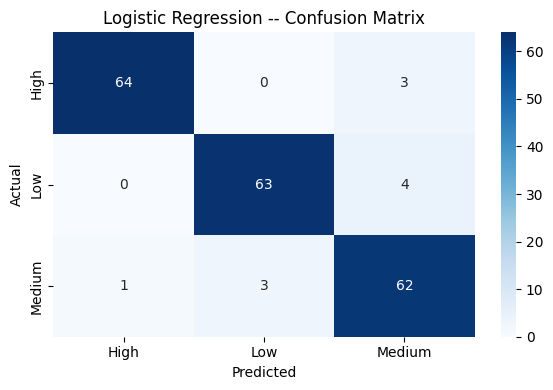

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1) Risk Skoru ve Risk Seviyesi Hesapla
# ----------------------------------------------------
df = user_anomaly_summary.copy()

# 1.a) Anomali sayısı sütunlarını normalize et
scaler_counts = MinMaxScaler()
count_cols = ['logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count']
df[[col + '_norm' for col in count_cols]] = scaler_counts.fit_transform(df[count_cols])

# 1.b) Anomali bayraklarından tek bir “flag_score” oluştur
df['flag_score'] = df[['logon_anomaly_flag', 'device_anomaly_flag', 'file_anomaly_flag']].mean(axis=1)

# 1.c) Psikometrik C, A, N sütunlarını normalize et ve “psych_risk” oluştur
scaler_psy = MinMaxScaler()
df[['C_norm', 'A_norm', 'N_norm']] = scaler_psy.fit_transform(df[['C', 'A', 'N']])
df['psych_risk'] = (1 - df['C_norm']) * 0.4 + (1 - df['A_norm']) * 0.3 + df['N_norm'] * 0.3

# 1.d) Nihai “risk_score” sütununu hesapla
df['risk_score'] = (
    df[[col + '_norm' for col in count_cols]].mean(axis=1) * 0.4 +
    df['flag_score'] * 0.2 +
    df['psych_risk'] * 0.4
)

# 1.e) “risk_level” etiketini qcut ile üç eşit parçaya bölerek oluştur
df['risk_level'] = pd.qcut(df['risk_score'], q=3, labels=['Low', 'Medium', 'High'])

print("Yeni Risk Seviyesi Dağılımı:\n", df['risk_level'].value_counts())

# ----------------------------------------------------
# 2) Modelleme için Özellik ve Hedef Değişkenlerini Hazırla
# ----------------------------------------------------
feature_cols = [
    'logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count',
    'logon_anomaly_flag', 'device_anomaly_flag', 'file_anomaly_flag',
    'O', 'C', 'E', 'A', 'N'
]

model_df = df[feature_cols + ['risk_level']].copy()

# Giriş ve hedef değişkenler
X = model_df.drop('risk_level', axis=1)
y = model_df['risk_level']

# Eğitim-test bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Sınıf etiketlerini sayısallaştır
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
classes = label_encoder.classes_  # ['High', 'Low', 'Medium']

# ----------------------------------------------------
# 3) Modelleri Tanımla ve Karşılaştır
# ----------------------------------------------------
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = []

for name, model in models.items():
    # Modeli eğit
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Performans metrikleri
    acc = accuracy_score(y_test_enc, y_pred)
    macro_f1 = f1_score(y_test_enc, y_pred, average='macro')
    report = classification_report(y_test_enc, y_pred, target_names=classes, zero_division=0)

    print(f"\n=== {name} ===")
    print(report)
    print(f"Accuracy: {acc:.2f}")
    print(f"Macro F1 Score: {macro_f1:.2f}")

    # Sonuçları kaydet
    results.append({
        'model': name,
        'accuracy': acc,
        'macro_f1': macro_f1
    })

# ----------------------------------------------------
# 4) En İyi Modeli Seç ve Göster
# ----------------------------------------------------
results_df = pd.DataFrame(results).sort_values(by='macro_f1', ascending=False).reset_index(drop=True)
best_model_name = results_df.loc[0, 'model']
best_macro_f1 = results_df.loc[0, 'macro_f1']
best_accuracy = results_df.loc[0, 'accuracy']

print(f"\n🏆 En İyi Model: {best_model_name} (Accuracy: {best_accuracy:.2f}, Macro F1: {best_macro_f1:.2f})")

# ----------------------------------------------------
# 5) Confusion Matrix Görselleştirmesi
# ----------------------------------------------------
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test_enc, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{best_model_name} -- Confusion Matrix')
plt.tight_layout()
plt.show()


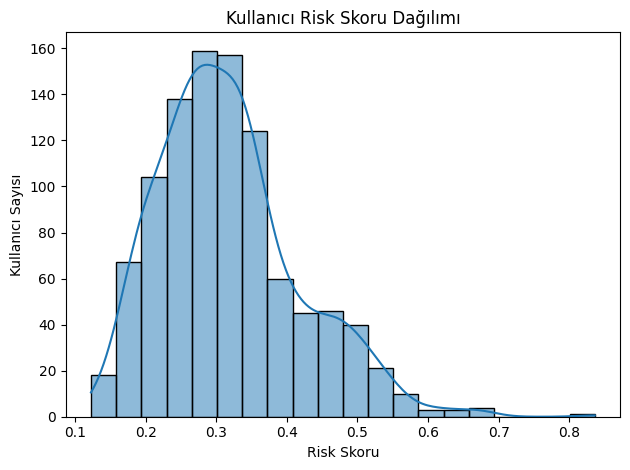

In [34]:
sns.histplot(df['risk_score'], kde=True, bins=20)
plt.title('Kullanıcı Risk Skoru Dağılımı')
plt.xlabel('Risk Skoru')
plt.ylabel('Kullanıcı Sayısı')
plt.tight_layout()
plt.show()


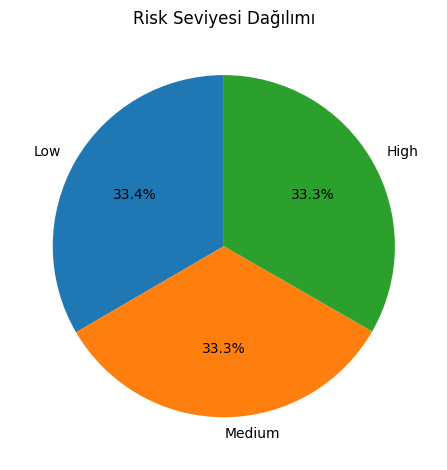

In [35]:
df['risk_level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ylabel='')
plt.title('Risk Seviyesi Dağılımı')
plt.tight_layout()
plt.show()


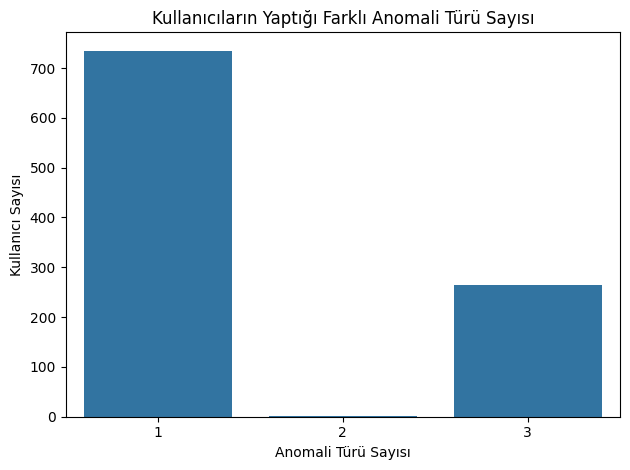

In [36]:
df['anomaly_type_count'] = df[['logon_anomaly_flag', 'device_anomaly_flag', 'file_anomaly_flag']].sum(axis=1)
sns.countplot(data=df, x='anomaly_type_count')
plt.title('Kullanıcıların Yaptığı Farklı Anomali Türü Sayısı')
plt.xlabel('Anomali Türü Sayısı')
plt.ylabel('Kullanıcı Sayısı')
plt.tight_layout()
plt.show()


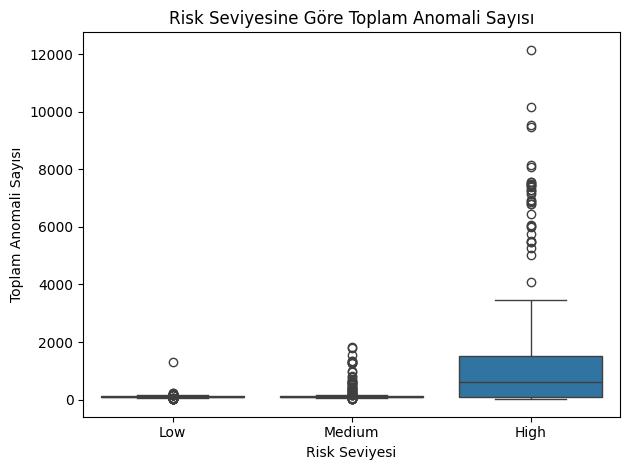

In [37]:
df['total_anomaly_count'] = df[['logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count']].sum(axis=1)
sns.boxplot(data=df, x='risk_level', y='total_anomaly_count')
plt.title('Risk Seviyesine Göre Toplam Anomali Sayısı')
plt.xlabel('Risk Seviyesi')
plt.ylabel('Toplam Anomali Sayısı')
plt.tight_layout()
plt.show()


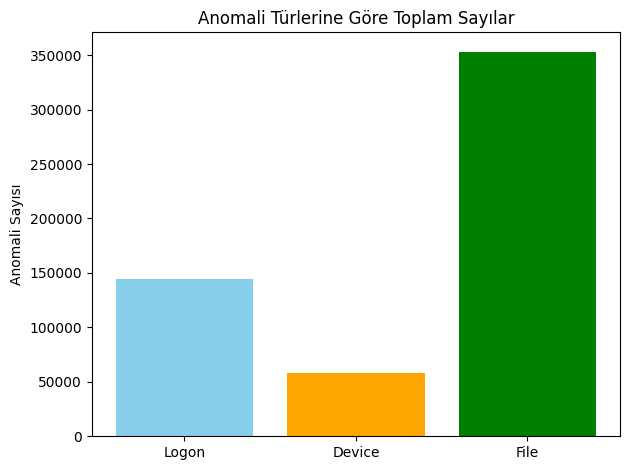

In [38]:
labels = ['Logon', 'Device', 'File']
counts = [
    logon_anomalies_final.shape[0],
    device_anomalies_final.shape[0],
    file_anomalies_final.shape[0]
]

plt.bar(labels, counts, color=['skyblue', 'orange', 'green'])
plt.title('Anomali Türlerine Göre Toplam Sayılar')
plt.ylabel('Anomali Sayısı')
plt.tight_layout()
plt.show()


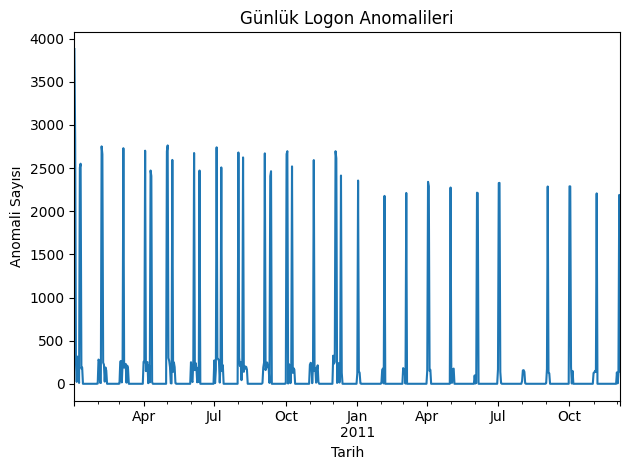

In [39]:
logon_anomalies_final['date'] = pd.to_datetime(logon_anomalies_final['date'])
logon_anomalies_final.set_index('date').resample('D').size().plot()
plt.title('Günlük Logon Anomalileri')
plt.ylabel('Anomali Sayısı')
plt.xlabel('Tarih')
plt.tight_layout()
plt.show()


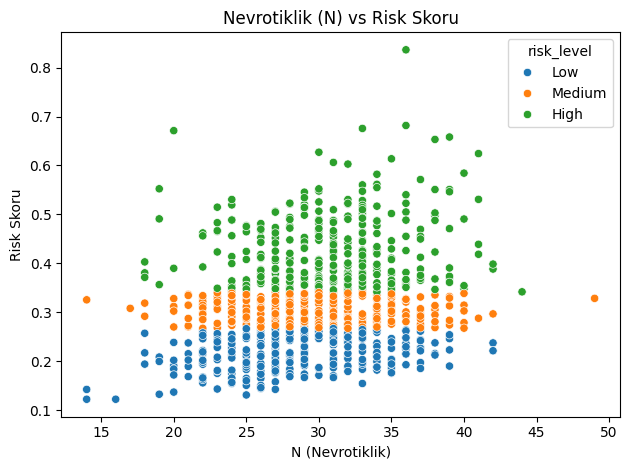

In [40]:
sns.scatterplot(data=df, x='N', y='risk_score', hue='risk_level')
plt.title('Nevrotiklik (N) vs Risk Skoru')
plt.xlabel('N (Nevrotiklik)')
plt.ylabel('Risk Skoru')
plt.tight_layout()
plt.show()


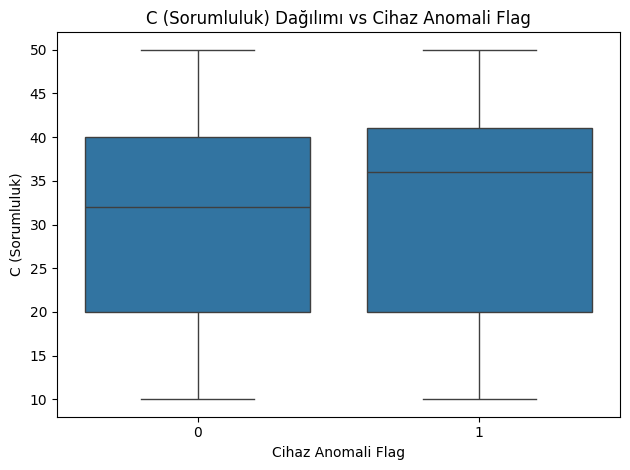

In [41]:
sns.boxplot(data=df, x='device_anomaly_flag', y='C')
plt.title('C (Sorumluluk) Dağılımı vs Cihaz Anomali Flag')
plt.xlabel('Cihaz Anomali Flag')
plt.ylabel('C (Sorumluluk)')
plt.tight_layout()
plt.show()


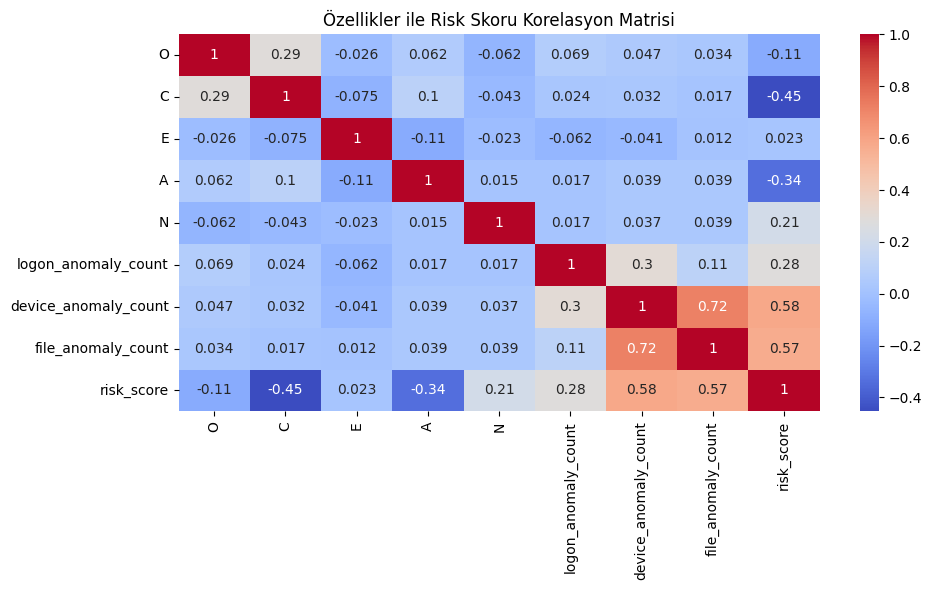

In [42]:
corr_cols = ['O', 'C', 'E', 'A', 'N', 'logon_anomaly_count', 'device_anomaly_count', 'file_anomaly_count', 'risk_score']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Özellikler ile Risk Skoru Korelasyon Matrisi')
plt.tight_layout()
plt.show()


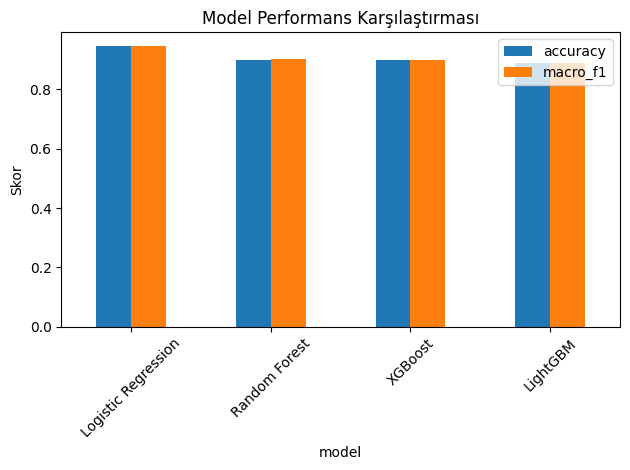

In [43]:
results_df.plot(x='model', y=['accuracy', 'macro_f1'], kind='bar')
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Skor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


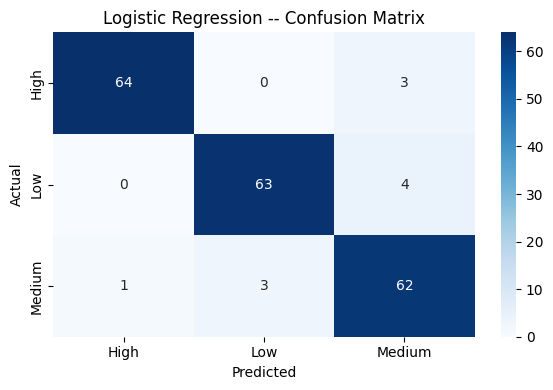

In [44]:
from sklearn.metrics import confusion_matrix

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test_enc, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{best_model_name} -- Confusion Matrix')
plt.tight_layout()
plt.show()
